In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import glob
import tools21cm as t2c
import cmasher as cmr
plt.rcParams['font.size'] = 12
save = False
plt.rcParams.update({"text.usetex": True,'font.family': 'serif','font.size':10})

In [2]:
zc = 63
N = 128
boxsize = 14 # kpc
extent = (0,boxsize,0,boxsize)

# Instructions to reproduce the plot from the paper
1. Create the directories `pyc2ray_results` and `test_results`
3. Execute `python shadow.py`, optionally with the `--gpu` flag to use ASORA
4. Move the output in `test_results` to a subdirectory of `pyc2ray_results` (or edit the cell below)

You can then either run the original C2Ray yourself to get the reference output, or download the data [here](https://drive.proton.me/urls/0W5XJ6WXXC#QWHTxmY9qQ99)

In [3]:
files_c2ray = [
    'c2ray_results/Teff=5e4/xfrac3D_8.835.bin'
]
files_pyc2ray = [
    'pyc2ray_results/Teff=5e4/xfrac_8.835.pkl'
]

files_c2ray_irate = [
    'c2ray_results/Teff=5e4/IonRates3D_8.835.bin'
]
files_pyc2ray_irate = [
    'pyc2ray_results/Teff=5e4/IonRates_8.835.pkl'
]

In [4]:
numslices = 1
xfrac_c2ray = np.empty((numslices,N,N,N))
xfrac_pyc2ray = np.empty((numslices,N,N,N))

irate_c2ray = np.empty((numslices,N,N,N))
irate_pyc2ray = np.empty((numslices,N,N,N))

slices_c2ray = np.empty((numslices,N,N))
slices_pyc2ray = np.empty((numslices,N,N))

slices_c2ray_irate = np.empty((numslices,N,N))
slices_pyc2ray_irate = np.empty((numslices,N,N))

for i,f in enumerate(files_c2ray):
    x = t2c.XfracFile(f).xi
    xfrac_c2ray[i] = x
    slices_c2ray[i] = x[:,:,zc]
    
for i,f in enumerate(files_pyc2ray):
    with open(f,"rb") as f:
        x = pkl.load(f)
    slices_pyc2ray[i] = x[:,:,zc]
    xfrac_pyc2ray[i] = x

for i,f in enumerate(files_c2ray_irate):
    phi = t2c.IonRateFile(f).irate
    slices_c2ray_irate[i] = phi[:,:,zc]
    irate_c2ray = phi
    
for i,f in enumerate(files_pyc2ray_irate):
    with open(f,"rb") as f:
        phi = pkl.load(f)
    slices_pyc2ray_irate[i] = phi[:,:,zc]
    irate_pyc2ray = phi

In [5]:
diff = (xfrac_pyc2ray - xfrac_c2ray) / xfrac_c2ray
diff_irate = (irate_pyc2ray - irate_c2ray) / irate_c2ray

In [6]:
vmin_x = slices_c2ray[0].min()
vmax_x = slices_c2ray[0].max()
cmap_x = 'Spectral_r' #'BuPu_r'#'BuPu_r'#'cmr.guppy_r'

vmin_r = -0.003
vmax_r = 0.003
cmap_r = 'RdBu'

vmin_irate = slices_c2ray_irate[0].min()
vmax_irate = slices_c2ray_irate[0].max()
cmap_irate = 'inferno'

def xfracplot(x,ax):
    return ax.imshow(x,norm='log',cmap=cmap_x,vmin=vmin_x,vmax=vmax_x,extent=extent,origin='lower')
def ionrateplot(x,ax):
    return ax.imshow(x,norm='log',cmap=cmap_irate,vmin=vmin_irate,vmax=vmax_irate,extent=extent,origin='lower')
def residplot(err,ax):
    return ax.imshow(err,cmap=cmap_r,vmin=vmin_r,vmax=vmax_r,extent=extent,origin='lower')

def errhistplot(diff,ax,errmin,errmax,errbinlim = 1e-10):
    abserr = np.abs(diff).flatten()
    errbin = np.logspace(errmin,errmax,20)
    wg = 100./(N*N*N) * np.ones(N*N*N)
    ax.set_xscale('log')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_box_aspect(1)
    return ax.hist(abserr, bins=errbin,weights=wg,color='darksalmon',ec='black')

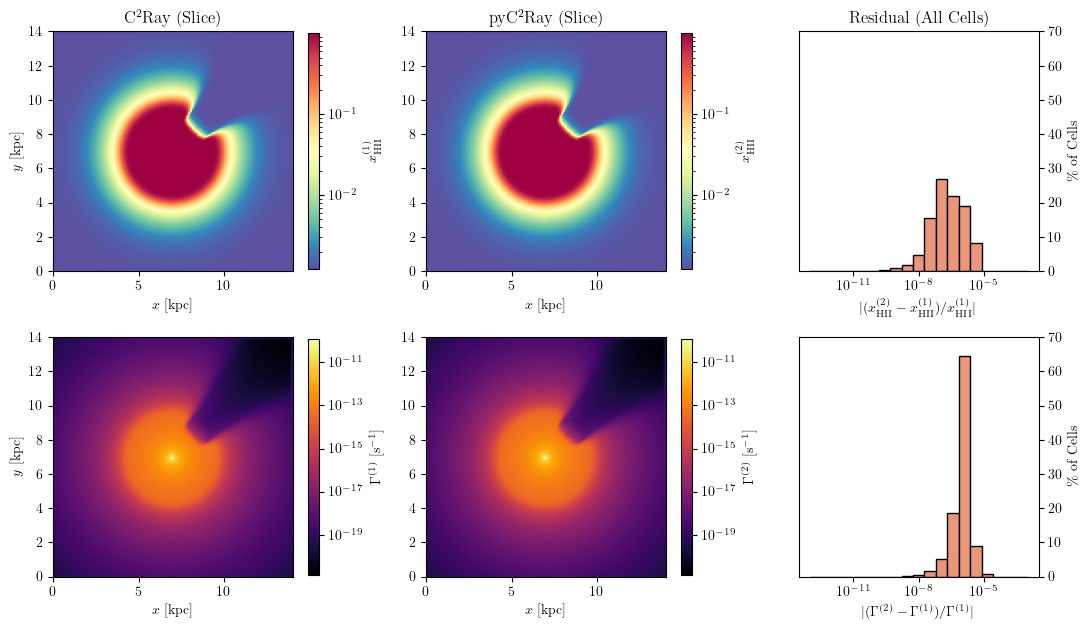

In [7]:
fig, ax = plt.subplots(2,3,figsize=(11,6.4),width_ratios=[5,5,4])

im1 = xfracplot(slices_c2ray[0],ax[0,0])
im2 = xfracplot(slices_pyc2ray[0],ax[0,1])
#res1 = residplot(err[0],ax[0,2])
res1 = errhistplot(diff,ax[0,2],-13,-3)

im3 = ionrateplot(slices_c2ray_irate[0],ax[1,0])
im4 = ionrateplot(slices_pyc2ray_irate[0],ax[1,1])
res2 = errhistplot(diff_irate,ax[1,2],-13,-3)

ax[1,2].set_ylim(0,70)
ax[0,2].set_ylim(0,70)
#res2 = residplot(err_irate[0],ax[1,2])

ax[1,0].set_xlabel('$x$ [kpc]')
ax[1,1].set_xlabel('$x$ [kpc]')
ax[0,0].set_xlabel('$x$ [kpc]')
ax[0,1].set_xlabel('$x$ [kpc]')
ax[1,2].set_xlabel("$|(\Gamma^{(2)}-\Gamma^{(1)})/\Gamma^{(1)}|$")
ax[0,2].set_xlabel("$|(x_\mathrm{{HII}}^{(2)}-x_\mathrm{{HII}}^{(1)})/x_\mathrm{{HII}}^{(1)}|$")
ax[1,2].set_ylabel('\% of Cells')
ax[0,2].set_ylabel('\% of Cells')
ax[0,0].set_ylabel('$y$ [kpc]')
ax[1,0].set_ylabel('$y$ [kpc]')

shrk = 0.95
cb1 = fig.colorbar(im1,ax=ax[0,0],shrink=shrk)
cb1.set_label("$x_\mathrm{{HII}}^{(1)}$")
cb2 = fig.colorbar(im2,ax=ax[0,1],shrink=shrk)
cb2.set_label("$x_\mathrm{{HII}}^{(2)}$")

cb3 = fig.colorbar(im3,ax=ax[1,0],shrink=shrk)
cb3.set_label("$\Gamma^{(1)}$ [s$^{-1}$]")
cb4 = fig.colorbar(im4,ax=ax[1,1],shrink=shrk)
cb4.set_label("$\Gamma^{(2)}$ [s$^{-1}$]")

#cbres1 = fig.colorbar(res1,ax=ax[0,2],shrink=shrk)
#cbres1.set_label("Relative Error [\%]")
#cbres2 = fig.colorbar(res2,ax=ax[1,2],shrink=shrk)
#cbres2.set_label("Relative Error [\%]")

ax[0,0].set_title("C$^2$Ray (Slice)")
ax[0,1].set_title("pyC$^2$Ray (Slice)")
ax[0,2].set_title("Residual (All Cells)")

#fig.subplots_adjust(hspace=0.05)
fig.tight_layout()

In [9]:
#fig.savefig("comparison_new.eps",dpi=300,bbox_inches='tight')
fig.savefig("test4_shadow.png",dpi=300,bbox_inches='tight')